# Bootstrap aggregation and link-confidence quantification with TIGRAMITE

TIGRAMITE is a time series analysis python module. It allows to reconstruct causal graphical models from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

This Nature Review Earth and Environment paper provides an overview of causal inference for time series in general: https://github.com/jakobrunge/tigramite/blob/master/tutorials/Runge_Causal_Inference_for_Time_Series_NREE.pdf

This tutorial explains **Bootstrap aggregation (bagging) for time series causal discovery**, which is implemented as the function `PCMCIbase.run_bootstrap_of`. The bootstrap aggregation is a general meta-algorithm that can be combined with most causal discovery methods of TIGRAMITE, e.g., `run_pcmci`, `run_pcalg_non_timeseries_data`, `run_pcmciplus`, `run_lpcmci`, among others, including the whole range of conditional independence tests. You can refer to the preprint below for additional information.

---
**Preprint on bootstrap aggregation and confidence measure for time series causal discovery:**
Debeire, K., Runge, J., Gerhardus, A., Eyring, V. (2023). Bootstrap aggregation and confidence measures to improve time series causal discovery. 
[https://arxiv.org/pdf/2306.08946](https://arxiv.org/pdf/2306.08946).

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline     

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.pcmci_base import PCMCIbase

## Bootstrap aggregation (bagging) and confidence estimation

In bootstrap-based bagging, a random sample in the training set is selected with replacement
—meaning that in each bootstrap sample each data point can be drawn more than once. Several data samples are generated in this fashion to produce a set of replicates (also called resamples). The machine learning models are
then trained independently on each replicate and, finally, the outputs are averaged for prediction tasks
or aggregated for classification tasks (for example by majority voting). In our case, the training set is the input time series, the machine learning model is the causal discovery method and the output is a causal graph.

The main interest of the bagging approach in time series causal discovery is to improve the robustness of the output graph and to provide confidence estimates for links in the graph. Since time series causal discovery is sensitive to temporal dependencies, it is essential to retain the temporal dependencies in the resampling procedure. However, standard resampling inevitably destroys (at least parts of) the temporal lagged dependencies. To resolve this problem, we employ the resampling strategy as illustrated below:

<img src="figures/bootstrap_for_timeseries.PNG" width=600px/> 

In the end, our bagging approach combined with a time series causal discovery method (here PCMCI+) can be summarized as follows: The original timeseries is resampled $B$ (number of bootstrap replicas) times. On each resample, PCMCI+ is run independently, resulting in one output graph. The $B$ output graphs are then aggregated by relative majority voting of the link types for each pair individually. Ties are resolved by the preference order (no link, ×−× and ◦−◦); and in case of a tie between → and ←, a conflicting link ×−× is returned.

The returned results of Bagged-PCMCI+ are: 

1. An ensemble of $B$ causal graphs from applying PCMCI+ to $B$ datasets that are obtained by resampling
with replacement while preserving temporal dependencies,

2. the aggregation of all these graphs by majority voting (at the level of each individual edge) to a final output graph, 

3. link frequencies for the final aggregated graph that provide a confidence measure for the links.

Below we represent this measure of confidence via the width of the links in the output graph: the confidence measure (proportionnal to the arrow widths) for $X_2 \rightarrow X_3$ at time lag 2 is larger than for $X_4 \rightarrow X_1$ at time lag 1.

<img src="figures/bagged_pcmciplus_summary.PNG" width=600px/> 

The bagged version has one further parameter compared to the chosen causal discovery algorithm: the number of bootstrap replicas $B$. In practice, we recommend to use $B$ as large as possible. The implementation uses parallelization via ``joblib``. In our numerical experiments $B=25$ gave already good results, but we recommend using $B\geq 100$. 

## Example

This section demonstrates and explains the application of Bagged-PCMCI+ on synthetic data.

### Data generation model

(<Figure size 640x480 with 1 Axes>, <Axes: >)

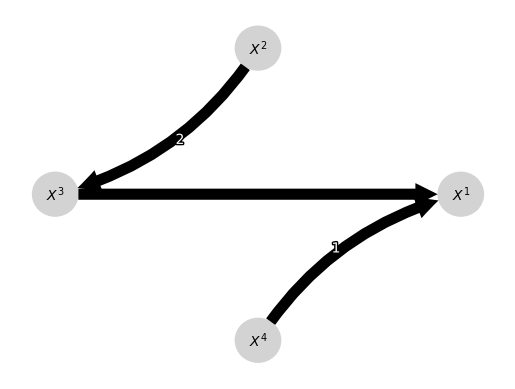

In [2]:
# Set seed for reproducibility
seed = 1111
# Choose the time series length
T = 100

# Specify the model (note that here, unlike in the typed equations, variables
# are indexed starting from 0)
def lin(x): return x

links = {0: [((0, -1), 0.3, lin), ((2, 0), 0.5, lin), ((3, -1), -0.5, lin)],   # X1
         1: [((1, -1), 0.3, lin)],                                             # X2
         2: [((2, -1), 0.3, lin), ((1, -2), 0.4, lin)],                        # X3
         3: [((3, -1), 0.3, lin)]                                              # X4                            
        }

var_names = [r'$X^{%d}$' % j for j in range(1, len(links)+1)]

# Show ground truth causal graph
tp.plot_graph(
    graph = PCMCI.get_graph_from_dict(links),
    var_names=var_names,
    )

We now generate data from a structural causal process with this graph.

In [3]:
# Generate data according to the full structural causal process
data, nonstationarity_indicator = toys.structural_causal_process(
    links=links, T=T, seed=seed)
assert not nonstationarity_indicator

# Number of variables
N = data.shape[1]

# Initialize dataframe object, specify variable names
dataframe = pp.DataFrame(data, var_names=var_names)

### Standard PCMCI+

We start by illustrating results with the standard PCMCI$^+$ method. Please consult the [tigramite overview tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_discovery/tigramite_tutorial_causal_discovery_overview.ipynb) for selecting hyperparameters in practice.

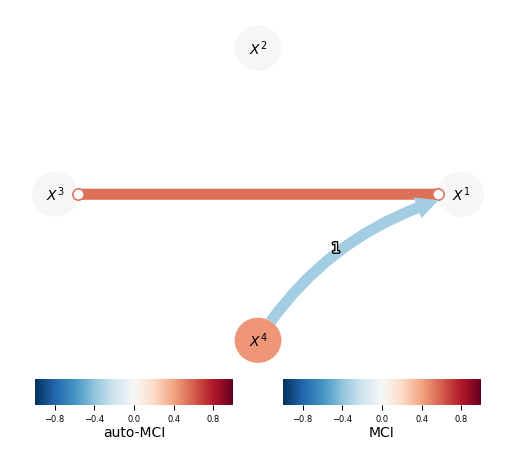

In [4]:
tau_max = 2
pc_alpha = 0.01

pcmci = PCMCI(dataframe=dataframe,
            cond_ind_test=ParCorr(),
            verbosity=0,
            )
results_pcmciplus = pcmci.run_pcmciplus(tau_max=tau_max, pc_alpha=pc_alpha)
tp.plot_graph(
    graph = results_pcmciplus['graph'],
    val_matrix= results_pcmciplus['val_matrix'],
    var_names=dataframe.var_names,
    ); plt.show()

Here PCMCI+ misses the link $X^2\to X^3$ and fails to orient the link $X^3\to X^1$. 

### Bagged-PCMCI+

From our numerical experiments, we found that Bagged-PCMCI+ improves upon precision of adjacencies and recall of orientations. However, one cannot directly compare results from Bagged-PCMCI+ versus PCMCI+ for the same ``pc_alpha`` (see precision-recall curves in the paper). Here we choose a higher ``pc_alpha`` for Bagged-PCMCI+. Further below we illustrate how to use model-selection to choose ``pc_alpha``.

Another parameter of Bagged-PCMCI+ is the block-length of the bootstrap (by default 1). It can optionally be used to better deal with autocorrelation, but its effect was not yet evaluated.

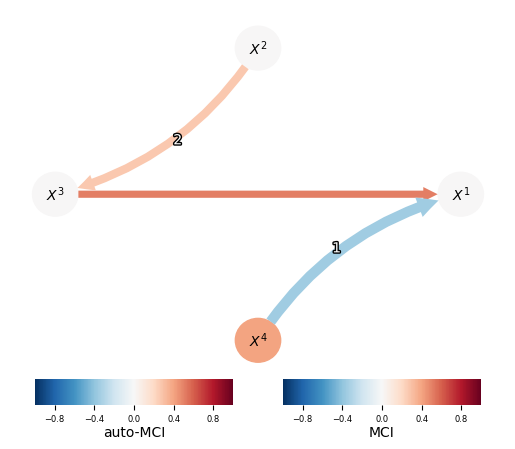

In [5]:
pc_alpha_bootstrap = 0.1
boot_samples = 200

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=ParCorr(),
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    ); plt.show()

In this example, we can see that Bagged-PCMCI+ gets the correct graph (link-wise majority vote among the $B$ resamples) and also provides a useful estimate of the confidence for links via the widths of the arrows.

### Bootstrap aggregation with optimized ``pc_alpha``

For a range of algorithms and conditional independence tests, it is also possible to set ``pc_alpha`` to a specficied list or to None (then the list [0.001, 0.005, 0.01, 0.025, 0.05] will be used). ``pc_alpha`` will then be optimized across the values specified in the list using the score computed in cond_ind_test.get_model_selection_criterion(). This is not possible for all conditional independence tests. 

This approach can also be combined with bootstrap-bagging. ``pc_alpha`` is internally and individually optimized for each of the  $B$ bootstrap resamples.

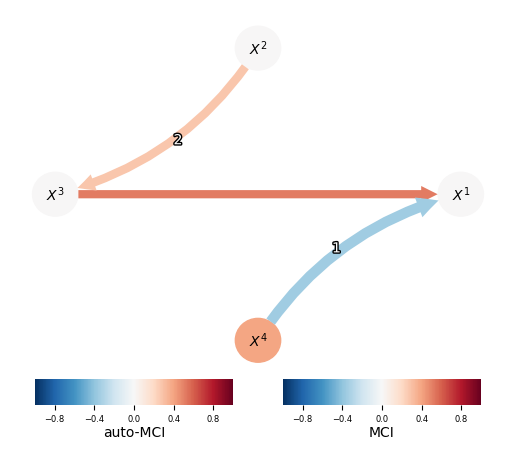

In [6]:
pc_alpha_bootstrap = [0.001, 0.01, 0.05, 0.1, 0.2] # This can be adapted 
boot_samples = 200

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=ParCorr(),
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    ); plt.show()

### Bootstrap aggregation with optimized ``pc_alpha`` for CMIknn

Finally, we showcase the Bagged-PCMCI+ approach with optimized ``pc_alpha`` and the nonlinear conditional independence test ``CMIknn``. See the corresponding [tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_discovery/tigramite_tutorial_conditional_independence_tests.ipynb). Using the standard initialization ``CMIknn(significance='shuffle_test')`` would result in each test carrying out a computationally intensive permutation-testing scheme to obtain the null distribution. An alternative with less statistical rigour is to just make test decisions based on a fixed threshold on the conditional mutual information using ``CMIknn(significance='fixed_thres')``, see the explanation in the tutorial. This is illustrated here.

We create nonlinear data as follows:

In [7]:
# Choose the time series length
T = 500

# Specify the model (note that here, unlike in the typed equations, variables
# are indexed starting from 0)
def lin(x): return x
def nonlin(x): return .2 * (x + 5. * x**2 * np.exp(-x**2 / 20.))

links = {0: [((0, -1), 0.3, lin), ((2, 0), 0.5, lin), ((3, -1), -0.7, nonlin)],   # X1
         1: [((1, -1), 0.3, lin)],                                             # X2
         2: [((2, -1), 0.3, lin), ((1, -2), 0.4, nonlin)],                        # X3
         3: [((3, -1), 0.3, lin)]                                              # X4                            
        }

# Generate data according to the full structural causal process
data, nonstationarity_indicator = toys.structural_causal_process(
    links=links, T=500, seed=seed)
# Initialize dataframe object, specify variable names
dataframe = pp.DataFrame(data, var_names=var_names)

In [8]:
# Use a range of fixed thresholds, these are used as pc_alpha (with a slight abuse of the parameter name)
# This can be adapted, higher thresholds lead to stricter link decisions and, hence, sparser graphs
fixed_thresholds = [0.01, 0.025, 0.05, 0.1]
boot_samples = 100

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=CMIknn(significance='fixed_thres', model_selection_folds=5),
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':fixed_thresholds}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

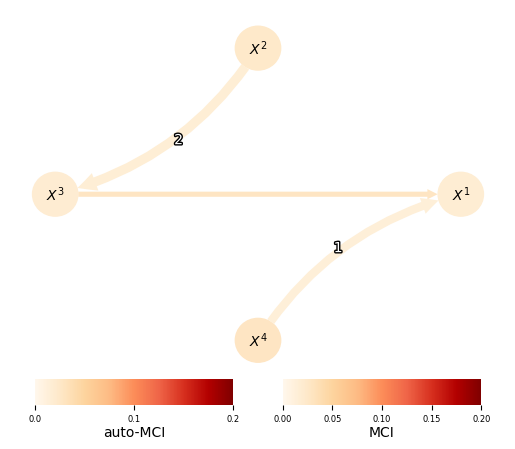

In [9]:
# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    vmin_edges=0.,
    vmax_edges = 0.2,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.2,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()